<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/U_Net_Klein_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Repeated tests with U-Net and Klein-beta plane

# **1. Imports and device**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

np.random.seed(123)
torch.manual_seed(123)
if device.type == "cuda":
    torch.cuda.manual_seed_all(123)


Using device: cpu


# **1. Klein-$\beta$ ICs (2-layer SW, A-grid)**

In [2]:
def make_ic_sw2l_klein_beta(
    Nx=64,
    Ny=32,
    g=9.81,
    H1=500.0,
    H2=500.0,
    f_p=1.0e-4,       # polar f
    A_bt=10.0,        # barotropic height amplitude
    A_bc=20.0,        # baroclinic height amplitude
    alpha=1.0,        # baroclinic strength
    R_frac=0.3,       # Gaussian radius fraction of π
    vel_noise=0.02,   # small random velocity noise
    f_min_frac=0.2,   # floor for |f| as fraction of |f_p|
    seed=None,
):
    """
    2-layer SW-like IC on Klein-β plane (A-grid):

      x ∈ [-π, π], y ∈ [-π/2, π/2]
      f = f_p * sin(y)
      Klein identifications at y = ±π/2:
        h(x, π/2)  =  h(-x, -π/2)
        u(x, π/2)  = -u(-x, -π/2)
        v(x, π/2)  =  v(-x, -π/2)
    """
    rng = np.random.RandomState(seed)

    # Grid
    dx = 2.0 * np.pi / Nx
    dy = np.pi / Ny
    x = -np.pi + (np.arange(Nx) + 0.5) * dx
    y = -0.5 * np.pi + (np.arange(Ny) + 0.5) * dy
    X, Y = np.meshgrid(x, y)

    # Coriolis and regularized f
    f = f_p * np.sin(Y)
    f_floor = f_min_frac * np.abs(f_p)
    f_eff = np.where(np.abs(f) < f_floor,
                     np.sign(f) * f_floor,
                     f)

    # Barotropic + baroclinic height anomalies
    eta_bt = A_bt * np.cos(X) * np.cos(2.0 * Y)

    x_c = rng.uniform(-0.5 * np.pi, 0.5 * np.pi)
    y_c = rng.uniform(-0.3 * np.pi, 0.3 * np.pi)
    R = R_frac * np.pi
    rr2 = (X - x_c) ** 2 + (Y - y_c) ** 2
    eta_bc = A_bc * np.exp(-rr2 / R**2) * np.cos(2.0 * X)

    eta1 = eta_bt + alpha * eta_bc
    eta2 = eta_bt - alpha * eta_bc

    h1 = np.maximum(H1 + eta1, 1.0)
    h2 = np.maximum(H2 + eta2, 1.0)

    # Derivatives
    def ddx(field):
        return (np.roll(field, -1, axis=1) - np.roll(field, 1, axis=1)) / (2.0 * dx)

    def ddy_rect(field):
        Ny_, Nx_ = field.shape
        d = np.zeros_like(field)
        d[1:-1, :] = (field[2:, :] - field[:-2, :]) / (2.0 * dy)
        d[0, :]    = (field[1, :] - field[0, :]) / dy
        d[-1, :]   = (field[-1, :] - field[-2, :]) / dy
        return d

    d_eta1_dx = ddx(eta1)
    d_eta1_dy = ddy_rect(eta1)
    d_eta2_dx = ddx(eta2)
    d_eta2_dy = ddy_rect(eta2)

    # Geostrophic-like velocities
    u1 = - (g / f_eff) * d_eta1_dy
    v1 =   (g / f_eff) * d_eta1_dx
    u2 = - (g / f_eff) * d_eta2_dy
    v2 =   (g / f_eff) * d_eta2_dx

    # Add small noise
    if vel_noise > 0.0:
        u1 += vel_noise * rng.randn(*u1.shape)
        v1 += vel_noise * rng.randn(*v1.shape)
        u2 += vel_noise * rng.randn(*u2.shape)
        v2 += vel_noise * rng.randn(*v2.shape)

    # Enforce Klein identifications at top/bottom
    Ny_, Nx_ = h1.shape
    j_bot = 0
    j_top = Ny_ - 1
    i_all = np.arange(Nx_)
    i_mirror = Nx_ - 1 - i_all

    # Scalars
    h1[j_top, i_all] = h1[j_bot, i_mirror]
    h2[j_top, i_all] = h2[j_bot, i_mirror]

    # Velocities
    u1[j_top, i_all] = -u1[j_bot, i_mirror]
    u2[j_top, i_all] = -u2[j_bot, i_mirror]
    v1[j_top, i_all] =  v1[j_bot, i_mirror]
    v2[j_top, i_all] =  v2[j_bot, i_mirror]

    return h1, h2, u1, v1, u2, v2


def build_ic_dataset_sw2l_klein_beta(
    N_samples=200,
    Nx=64,
    Ny=32,
    base_seed=123,
):
    """
    Static 2-layer SW ICs on Klein-β plane.
    Returns truth: (N_samples, 6, Ny, Nx)
    """
    C_state = 6
    truth = np.zeros((N_samples, C_state, Ny, Nx), dtype=np.float32)

    for i in range(N_samples):
        seed = base_seed + i
        A_bt = 10.0 * (0.5 + np.random.rand())
        A_bc = 20.0 * (0.5 + np.random.rand())

        h1, h2, u1, v1, u2, v2 = make_ic_sw2l_klein_beta(
            Nx=Nx,
            Ny=Ny,
            A_bt=A_bt,
            A_bc=A_bc,
            seed=seed,
        )

        truth[i, 0] = h1
        truth[i, 1] = h2
        truth[i, 2] = u1
        truth[i, 3] = v1
        truth[i, 4] = u2
        truth[i, 5] = v2

    return truth


NX = 64
NY = 32
truth_static = build_ic_dataset_sw2l_klein_beta(N_samples=200, Nx=NX, Ny=NY)
print("truth_static shape:", truth_static.shape)


truth_static shape: (200, 6, 32, 64)


# **3. Anomalies + per-channel normalization**

In [3]:
N, C_state, H, W = truth_static.shape
var_names = ["h1", "h2", "u1", "v1", "u2", "v2"]

channel_means = truth_static.mean(axis=(0, 2, 3), keepdims=True)  # (1,6,1,1)
truth_anom = truth_static - channel_means

# std per channel
channel_std = truth_anom.reshape(N, C_state, -1).std(axis=(0, 2), keepdims=True)  # (1,6,1)
channel_std_safe = np.where(channel_std == 0.0, 1.0, channel_std)
channel_std_safe = channel_std_safe.reshape(1, C_state, 1, 1)

truth_norm = truth_anom / channel_std_safe  # (N,6,H,W)

print("Channel means:", channel_means.reshape(-1))
print("Channel std (anom):", channel_std.reshape(-1))


Channel means: [ 4.9997363e+02  5.0002637e+02 -2.9284363e+03 -1.2759327e-04
  2.9284375e+03  1.3961792e-05]
Channel std (anom): [6.7010951e+00 6.1396427e+00 2.1956595e+06 3.1705648e+06 1.9986376e+06
 2.8945930e+06]


# **4. Obs: scattered in space + periodic-x Gaussian RBF -> grid**

In [4]:
def sample_field_bilinear(field_2d, x, y):
    """
    Bilinear sampling in index-space (0..W, 0..H).
    x: (n_obs,), y: (n_obs,)
    Periodic in x, clamped in y.
    """
    H, W = field_2d.shape
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    v00 = field_2d[y0, x0]
    v10 = field_2d[y0, x1]
    v01 = field_2d[y1, x0]
    v11 = field_2d[y1, x1]

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    vals = w00 * v00 + w10 * v10 + w01 * v01 + w11 * v11
    return vals


def rbf_to_grid_gaussian_periodic_x(x_obs, y_obs, vals, H, W, sigma_pix=3.0, eps=1e-6):
    """
    Gaussian RBF to grid with periodic distance in x, Euclidean in y.
    """
    Xg, Yg = np.meshgrid(np.arange(W), np.arange(H))
    Xg_flat = Xg.reshape(-1, 1)
    Yg_flat = Yg.reshape(-1, 1)

    x_obs = x_obs.reshape(1, -1)
    y_obs = y_obs.reshape(1, -1)

    dx_raw = Xg_flat - x_obs
    dy = Yg_flat - y_obs

    dx_abs = np.abs(dx_raw)
    dx = np.minimum(dx_abs, W - dx_abs)  # periodic in x

    r2 = dx * dx + dy * dy

    K = np.exp(-r2 / (2.0 * sigma_pix**2)).astype(np.float32)

    weights = K.sum(axis=1)
    weighted_vals = (K * vals.reshape(1, -1)).sum(axis=1)

    grid_flat = weighted_vals / (weights + eps)
    grid = grid_flat.reshape(H, W)
    weight_map = weights.reshape(H, W)

    return grid, weight_map


def make_obs_dataset_rbf_klein(
    truth_norm,
    n_obs_points=800,
    sigma_pix=3.0,
    noise_frac=0.1,
    seed=123,
):
    """
    Obs dataset for Klein-β:
      - truth_norm: (N,6,H,W) normalized anomalies
      - X: [RBF obs grid, mask] (N, 12, H, W)
      - Y: truth_norm (N, 6, H, W)
    """
    rng = np.random.RandomState(seed)
    N, C, H, W = truth_norm.shape

    # channel std of *normalized* anomalies is ~1, but we recompute for noise scaling
    channel_std = truth_norm.reshape(N, C, -1).std(axis=(0, 2))
    print("Channel std (normalized):", channel_std)

    X = np.zeros((N, 2 * C, H, W), dtype=np.float32)
    Y = truth_norm.astype(np.float32).copy()

    for i in range(N):
        field = truth_norm[i]  # (6,H,W)
        x_obs = rng.uniform(0.0, W, size=n_obs_points)
        y_obs = rng.uniform(0.0, H, size=n_obs_points)

        obs_grid  = np.zeros((C, H, W), dtype=np.float32)
        mask_grid = np.zeros((C, H, W), dtype=np.float32)

        for c in range(C):
            fld_c = field[c]
            vals_clean = sample_field_bilinear(fld_c, x_obs, y_obs)

            sigma_c = noise_frac * channel_std[c]
            noise = sigma_c * rng.randn(n_obs_points) if sigma_c > 0 else 0.0
            vals = vals_clean + noise

            g_c, w_c = rbf_to_grid_gaussian_periodic_x(
                x_obs, y_obs, vals, H, W, sigma_pix=sigma_pix
            )
            obs_grid[c] = g_c
            mask_grid[c] = (w_c / w_c.max()).astype(np.float32) if w_c.max() > 0 else 0.0

        X[i] = np.concatenate([obs_grid, mask_grid], axis=0)

    return X, Y


n_obs_points = 800
sigma_pix    = 3.0
noise_frac   = 0.1

X, Y = make_obs_dataset_rbf_klein(
    truth_norm,
    n_obs_points=n_obs_points,
    sigma_pix=sigma_pix,
    noise_frac=noise_frac,
    seed=123,
)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


Channel std (normalized): [0.9999998  1.         0.9999999  1.0000001  0.99999994 1.        ]
X shape: (200, 12, 32, 64)
Y shape: (200, 6, 32, 64)


# **5. U-Net with periodic-x, wall-like y convs**

In [5]:
class PeriodicXConv2d(nn.Module):
    """
    3x3 conv:
      - periodic in x
      - reflect in y (wall-like)
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pad = 1
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=0)
        self.bn   = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        p = self.pad
        # periodic x pad
        x = torch.cat([x[..., -p:], x, x[..., :p]], dim=3)
        # reflect y pad
        x = F.pad(x, (0, 0, p, p), mode="reflect")
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class DoubleConvPeriodicX(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = PeriodicXConv2d(in_ch, out_ch)
        self.conv2 = PeriodicXConv2d(out_ch, out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConvPeriodicX(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = DoubleConvPeriodicX(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1,
                   [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2],
                   mode="reflect")
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet2D_Klein(nn.Module):
    """
    U-Net for Klein-β DA:
      input:  (B, C_in, H, W)  [RBF obs, mask]
      output: (B, 6, H, W) normalized anomalies
    """
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc   = DoubleConvPeriodicX(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.up1   = Up(128 + 64, 64)
        self.up2   = Up(64 + 32, 32)
        self.outc  = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x  = self.up1(x3, x2)
        x  = self.up2(x,  x1)
        logits = self.outc(x)
        return logits


N, C_in, H, W = X.shape
C_state = Y.shape[1]
print("N, C_in, C_state, H, W =", N, C_in, C_state, H, W)

model_unet = UNet2D_Klein(n_channels=C_in, n_classes=C_state).to(device)
print(model_unet)


N, C_in, C_state, H, W = 200 12 6 32 64
UNet2D_Klein(
  (inc): DoubleConvPeriodicX(
    (conv1): PeriodicXConv2d(
      (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): PeriodicXConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConvPeriodicX(
      (conv1): PeriodicXConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): PeriodicXConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# **6. Data loaders + interior /wind-aware loss**

In [6]:
X_torch = torch.from_numpy(X)
Y_torch = torch.from_numpy(Y)

idx = np.arange(N)
np.random.shuffle(idx)
n_train = int(0.8 * N)
idx_train = idx[:n_train]
idx_val   = idx[n_train:]

train_ds = TensorDataset(X_torch[idx_train], Y_torch[idx_train])
val_ds   = TensorDataset(X_torch[idx_val],   Y_torch[idx_val])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

# Interior mask
BORDER_ROWS = 2
interior_mask_np = np.ones((1, 1, H, W), dtype=np.float32)
interior_mask_np[:, :, :BORDER_ROWS, :]  = 0.0
interior_mask_np[:, :, -BORDER_ROWS:, :] = 0.0
interior_mask = torch.from_numpy(interior_mask_np).to(device)

criterion = nn.MSELoss(reduction="none")

# weights for channels: [h1,h2,u1,v1,u2,v2]
w_channels = np.array([1.0, 1.0, 2.0, 2.0, 2.0, 2.0], dtype=np.float32)
w_channels_t = torch.from_numpy(w_channels.reshape(1, C_state, 1, 1)).to(device)

def loss_interior_weighted(pred, target):
    """
    interior-only, wind-weighted MSE
    """
    se = (pred - target) ** 2                      # (B,C,H,W)
    se = se * interior_mask * w_channels_t         # broadcast
    se_sum = se.sum()
    n_spatial = interior_mask.sum()
    B, C, _, _ = pred.shape
    n_total = n_spatial * B * C
    return se_sum / n_total


def eval_rmse_interior(model, loader, device):
    model.eval()
    se_sum = 0.0
    n_vals = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            se = (out - yb) ** 2 * interior_mask
            se_sum += se.sum().item()
            B, C, _, _ = out.shape
            n_vals += interior_mask.sum().item() * B * C
    mse = se_sum / n_vals
    return np.sqrt(mse)


Train samples: 160 Val samples: 40


# **7. Training**

Epoch 001 | train_loss=1.373e+00 | val_RMSE_int=9.805e-01
Epoch 002 | train_loss=9.398e-01 | val_RMSE_int=7.539e-01
Epoch 003 | train_loss=7.551e-01 | val_RMSE_int=6.254e-01
Epoch 004 | train_loss=6.227e-01 | val_RMSE_int=5.745e-01
Epoch 005 | train_loss=5.148e-01 | val_RMSE_int=5.167e-01
Epoch 006 | train_loss=4.320e-01 | val_RMSE_int=4.747e-01
Epoch 007 | train_loss=3.629e-01 | val_RMSE_int=4.365e-01
Epoch 008 | train_loss=3.113e-01 | val_RMSE_int=4.260e-01
Epoch 009 | train_loss=2.666e-01 | val_RMSE_int=3.856e-01
Epoch 010 | train_loss=2.384e-01 | val_RMSE_int=3.626e-01
Epoch 011 | train_loss=2.105e-01 | val_RMSE_int=3.448e-01
Epoch 012 | train_loss=1.854e-01 | val_RMSE_int=3.256e-01
Epoch 013 | train_loss=1.641e-01 | val_RMSE_int=3.056e-01
Epoch 014 | train_loss=1.529e-01 | val_RMSE_int=3.002e-01
Epoch 015 | train_loss=1.415e-01 | val_RMSE_int=2.838e-01
Epoch 016 | train_loss=1.289e-01 | val_RMSE_int=2.681e-01
Epoch 017 | train_loss=1.172e-01 | val_RMSE_int=2.564e-01
Epoch 018 | tr

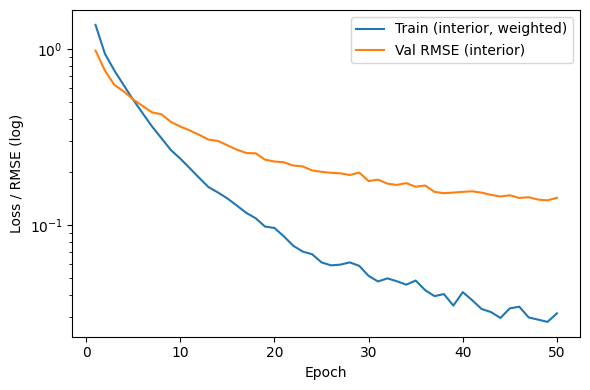

In [7]:
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=1e-4)

n_epochs = 50
train_losses = []
val_rmses = []

for epoch in range(1, n_epochs + 1):
    model_unet.train()
    total_loss = 0.0
    n_samp = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model_unet(xb)
        loss = loss_interior_weighted(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n_samp += xb.size(0)

    train_loss = total_loss / n_samp
    val_rmse = eval_rmse_interior(model_unet, val_loader, device)

    train_losses.append(train_loss)
    val_rmses.append(val_rmse)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.3e} | val_RMSE_int={val_rmse:.3e}")

# Curves
epochs_arr = np.arange(1, n_epochs + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs_arr, train_losses, label="Train (interior, weighted)")
plt.plot(epochs_arr, val_rmses, label="Val RMSE (interior)")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE (log)")
plt.legend()
plt.tight_layout()
plt.show()


# **8. Plot anomalies: Truth vs recon (normalized)**

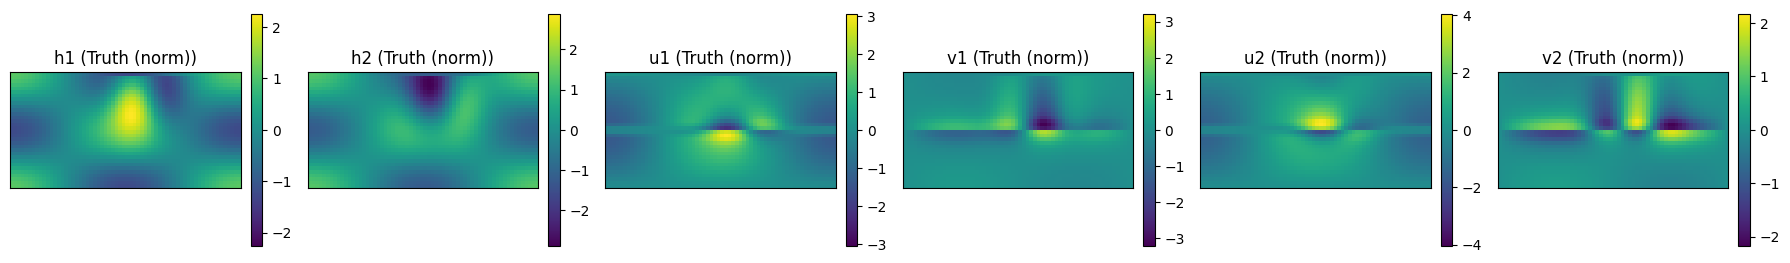

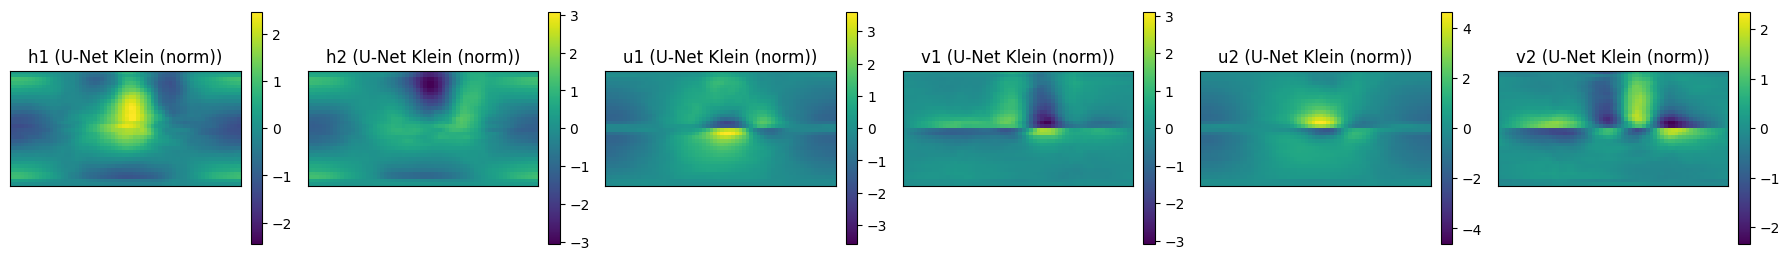

Sample RMSE (all vars, interior+edges, norm units): 0.16707392


In [8]:
def plot_anomalies_all_vars(data, idx=0, var_names=None, title_prefix=""):
    sample = data[idx]  # (C,H,W)
    C, H, W = sample.shape
    if var_names is None:
        var_names = [f"var{c}" for c in range(C)]

    fig, axs = plt.subplots(1, C, figsize=(3*C, 3))
    if C == 1:
        axs = [axs]

    for c in range(C):
        fld = sample[c]
        anom = fld - fld.mean()
        vmax = np.max(np.abs(anom))
        if vmax == 0:
            vmax = 1e-6
        vmin, vmax = -vmax, vmax

        im = axs[c].imshow(anom, origin="lower", vmin=vmin, vmax=vmax)
        axs[c].set_title(f"{var_names[c]} ({title_prefix})")
        axs[c].set_xticks([]); axs[c].set_yticks([])
        plt.colorbar(im, ax=axs[c], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


model_unet.eval()
with torch.no_grad():
    xb_batch, yb_batch = next(iter(val_loader))
    xb_batch = xb_batch.to(device)
    yb_batch = yb_batch.to(device)
    y_pred_batch = model_unet(xb_batch)

y_true = yb_batch.cpu().numpy()
y_pred = y_pred_batch.cpu().numpy()

idx_example = 0

plot_anomalies_all_vars(y_true, idx=idx_example, var_names=var_names, title_prefix="Truth (norm)")
plot_anomalies_all_vars(y_pred, idx=idx_example, var_names=var_names, title_prefix="U-Net Klein (norm)")

sample_rmse = np.sqrt(((y_true[idx_example] - y_pred[idx_example])**2).mean())
print("Sample RMSE (all vars, interior+edges, norm units):", sample_rmse)
